<a href="https://colab.research.google.com/github/rjnakano/manejo-inventarios-pdg/blob/main/Notebooks/2-modelos-data-fixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install seaborn
!pip install kmodes
!pip install plotnine

In [2]:
import pathlib
import pandas as pd
import numpy as np
import seaborn as sns
import plotnine
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from kmodes.kprototypes import KPrototypes
from plotnine import *

In [3]:
if str(pathlib.Path().absolute()).find('content') >= 0:
    sourcepath = 'https://raw.githubusercontent.com/rjnakano/manejo-inventarios-pdg/main/Datos/Transformed'
else:
    sourcepath = '../Datos/Transformed'
print(sourcepath)    

https://raw.githubusercontent.com/rjnakano/manejo-inventarios-pdg/main/Datos/Transformed


In [4]:
dfTest1 = pd.read_csv('{}/dfNoDims.csv'.format(sourcepath))
dfTest1.AISLE = dfTest1.AISLE.astype(str)

In [5]:
# Remover registros inconsistentes con las reglas de negocio
dfTest1 = dfTest1[
    -(((dfTest1.COSTX > 0) & (dfTest1.QTYVAR < 0)) |
    ((dfTest1.COSTX < 0) & (dfTest1.QTYVAR > 0)))
]
dfTest1 = dfTest1.reset_index(drop=True)

In [6]:
dfTest1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16239 entries, 0 to 16238
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AISLE      16239 non-null  object 
 1   IG         16239 non-null  object 
 2   HTS        16239 non-null  object 
 3   PLANNING   16239 non-null  object 
 4   ABC        16239 non-null  object 
 5   UOM        16239 non-null  object 
 6   CAT        16239 non-null  object 
 7   COSTX      16239 non-null  float64
 8   QTYVAR     16239 non-null  float64
 9   CONTRPERC  16239 non-null  float64
dtypes: float64(3), object(7)
memory usage: 1.2+ MB


In [7]:
dfTest1.tail()

,AISLE,IG,HTS,PLANNING,ABC,UOM,CAT,COSTX,QTYVAR,CONTRPERC
16234,23,IG5,HTS67,1/0,C,BX,CAT2,316.3834,1.00,0.0
16235,21,IG5,HTS67,1/0,C,BX,CAT2,626.9100,1.00,0.0
16236,22,IG5,HTS67,1/0,C,BX,CAT2,4959.6974,136.36,0.0
16237,24,IG5,HTS67,1/0,C,BX,CAT2,-1322.5860,-100.00,0.0
16238,20,IG5,HTS67,1/0,C,BX,CAT2,-255.2001,-50.00,0.0


In [8]:
dfTest1.drop('CONTRPERC', inplace=True, axis=1)

In [9]:
# Get the position of categorical columns
catColumnsPos = [dfTest1.columns.get_loc(col) for col in list(dfTest1.select_dtypes('object').columns)]
print('Categorical columns : {}'.format(list(dfTest1.select_dtypes('object').columns)))
print('Categorical columns position : {}'.format(catColumnsPos))

Categorical columns : ['AISLE', 'IG', 'HTS', 'PLANNING', 'ABC', 'UOM', 'CAT']
Categorical columns position : [0, 1, 2, 3, 4, 5, 6]


In [10]:
# Get the position of numerical columns
numColumnsPos = [dfTest1.columns.get_loc(col) for col in list(dfTest1.select_dtypes('float64').columns)]
print('Numerical columns : {}'.format(list(dfTest1.select_dtypes('float64').columns)))
print('Numerical columns position : {}'.format(numColumnsPos))

Numerical columns : ['COSTX', 'QTYVAR']
Numerical columns position : [7, 8]


In [11]:
numdf = dfTest1[list(dfTest1.select_dtypes('float64').columns)]

In [12]:
scaled_features = StandardScaler().fit_transform(numdf.values)
scaled_features_df = pd.DataFrame(scaled_features, index=numdf.index, columns=numdf.columns)
scaled_features_df

,COSTX,QTYVAR
0,-0.029976,-0.037185
1,0.092472,-0.006928
2,0.266130,0.020450
3,-0.025112,-0.044259
4,-0.077982,-0.046471
...,...,...
16234,0.098142,-0.033210
16235,0.163764,-0.033210
16236,1.079388,0.115021
16237,-0.248212,-0.143814


In [13]:
catdf = dfTest1[list(dfTest1.select_dtypes('object').columns)]

In [14]:
print("catdf",catdf.shape)
print("scaled_features_df",scaled_features_df.shape)
print(catdf.head(5))
print(scaled_features_df.head(5))
print(catdf.tail(5))
print(scaled_features_df.tail(5))
dfNoSupervisado1 = pd.concat((catdf, scaled_features_df), axis = 1)
dfNoSupervisado1

catdf (16239, 7)
scaled_features_df (16239, 2)
  AISLE    IG     HTS PLANNING ABC UOM    CAT
0    17  IG56  HTS119      1/1   B  PC  CAT17
1    17  IG56  HTS119      1/1   B  PC  CAT17
2    17  IG56  HTS119      1/1   C  PC  CAT17
3    17  IG56  HTS119      1/1   B  PC  CAT17
4    15  IG56  HTS119      1/1   C  PC  CAT17
      COSTX    QTYVAR
0 -0.029976 -0.037185
1  0.092472 -0.006928
2  0.266130  0.020450
3 -0.025112 -0.044259
4 -0.077982 -0.046471
      AISLE   IG    HTS PLANNING ABC UOM   CAT
16234    23  IG5  HTS67      1/0   C  BX  CAT2
16235    21  IG5  HTS67      1/0   C  BX  CAT2
16236    22  IG5  HTS67      1/0   C  BX  CAT2
16237    24  IG5  HTS67      1/0   C  BX  CAT2
16238    20  IG5  HTS67      1/0   C  BX  CAT2
          COSTX    QTYVAR
16234  0.098142 -0.033210
16235  0.163764 -0.033210
16236  1.079388  0.115021
16237 -0.248212 -0.143814
16238 -0.022648 -0.089059


,AISLE,IG,HTS,PLANNING,ABC,UOM,CAT,COSTX,QTYVAR
0,17,IG56,HTS119,1/1,B,PC,CAT17,-0.029976,-0.037185
1,17,IG56,HTS119,1/1,B,PC,CAT17,0.092472,-0.006928
2,17,IG56,HTS119,1/1,C,PC,CAT17,0.266130,0.020450
3,17,IG56,HTS119,1/1,B,PC,CAT17,-0.025112,-0.044259
4,15,IG56,HTS119,1/1,C,PC,CAT17,-0.077982,-0.046471
...,...,...,...,...,...,...,...,...,...
16234,23,IG5,HTS67,1/0,C,BX,CAT2,0.098142,-0.033210
16235,21,IG5,HTS67,1/0,C,BX,CAT2,0.163764,-0.033210
16236,22,IG5,HTS67,1/0,C,BX,CAT2,1.079388,0.115021
16237,24,IG5,HTS67,1/0,C,BX,CAT2,-0.248212,-0.143814


In [15]:
# dfNoSupervisado1.to_csv('{}/dfNoSupervisado_fixed.csv'.format(sourcepath))

In [16]:
import numba as nb

In [17]:
from sklearn.metrics import silhouette_score
import time

dfNoSupervisado1.reset_index(drop=True)
N = dfNoSupervisado1.shape[0]

dataNum= dfNoSupervisado1.iloc[:,numColumnsPos]
dataNum=dataNum.to_numpy()
print('Datos numéricos',type(dataNum))

dataCat=dfNoSupervisado1.iloc[:,catColumnsPos]
dataCat=dataCat.to_numpy()
print('Datos categóricos',type(dataCat))

# gamma = 0.5 (constante)
catWeight=0.5

start_time = time.time()

Datos numéricos <class 'numpy.ndarray'>
Datos categóricos <class 'numpy.ndarray'>


In [18]:
@nb.njit
def dist_num_njit(data):
    scores = np.zeros((len(data),len(data)), dtype=np.float64)
    valor = nb.float64(0)

    for i in range(len(data)):
        for j in range(i+1, len(data)):
            valor = nb.float64(np.sum((data[i] - data[j]) ** 2))
            scores[i][j] = valor
    return scores

In [19]:
def dist_cat(data, catWeight):
    scores = np.zeros((len(data),len(data)), dtype=np.float64)
    for i in range(len(data)):
        for j in range(i+1, len(data)):
            scores[i][j] = np.float64(np.sum(data[i]!=data[j])*catWeight)
    return scores

In [20]:
@nb.njit
def traspose_njit (data):
    scores = data
    for i in range(len(data)):
        for j in range(1+i,len(data)):
            scores[j][i] = scores[i][j]
    return scores            

In [21]:
# Todavía no está implementado correctamente
def get_scores(data,catWeight):
    %time dist_num_np = dist_num_njit(dataNum[range(i)])
    %time dist_cat_np = dist_cat(dataCat[range(i)], catWeight)
    %time total = np.sum([dist_cat_np, dist_num_np], axis=0)
    %time total = traspose_njit(total)

In [22]:
filename='scores_fixed.csv'
if not Path('{}/{}'.format(sourcepath,filename)).is_file():
    start_time = time.time()
    for i in [10, dataNum.shape[0]]:
        print('Número de filas a procesar: {}'.format(i))
        %time dist_num_np = dist_num_njit(dataNum[range(i)])
        %time dist_cat_np = dist_cat(dataCat[range(i)], catWeight)
        %time total = np.sum([dist_cat_np, dist_num_np], axis=0)
        %time total = traspose_njit(total)
        print()
    %time np.savetxt('{}/{}'.format(sourcepath,filename),total, delimiter=',')  
    print('Tiempo total = {}'.format(time.time() - start_time))
else: 
    print('El archivo {} ya existe'.format(filename))

Número de filas a procesar: 10
CPU times: user 744 ms, sys: 22.4 ms, total: 767 ms
Wall time: 809 ms
CPU times: user 604 µs, sys: 0 ns, total: 604 µs
Wall time: 608 µs
CPU times: user 66 µs, sys: 0 ns, total: 66 µs
Wall time: 69.9 µs
CPU times: user 137 ms, sys: 2.05 ms, total: 139 ms
Wall time: 138 ms

Número de filas a procesar: 16239
CPU times: user 17 s, sys: 1.06 s, total: 18 s
Wall time: 18 s
CPU times: user 24min 11s, sys: 3.25 s, total: 24min 14s
Wall time: 24min 17s
CPU times: user 2.24 s, sys: 2.17 s, total: 4.41 s
Wall time: 4.41 s
CPU times: user 1.05 s, sys: 4.01 ms, total: 1.05 s
Wall time: 1.05 s



FileNotFoundError: ignored

In [23]:
if len(total)>0:
    scores = pd.DataFrame(total)
else: 
    %time scores = pd.read_csv('{}/{}'.format(sourcepath,filename),header=None)

In [25]:
scores.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,16199,16200,16201,16202,16203,16204,16205,16206,16207,16208,16209,16210,16211,16212,16213,16214,16215,16216,16217,16218,16219,16220,16221,16222,16223,16224,16225,16226,16227,16228,16229,16230,16231,16232,16233,16234,16235,16236,16237,16238
16234,3.516430,3.500723,3.031099,3.515314,3.031195,9.501473,3.603311,6.911404,3.511169,3.510314,3.500408,4.661301,3.943043,3.593306,4.253391,3.008464,3.546746,3.596348,3.554132,2.519429,2.660673,2.843473,2.793810,2.951996,2.500197,2.512871,2.870338,2.925012,6.733787,3.513222,3.500953,3.519344,3.989071,3.506233,3.530273,3.530273,3.613905,3.007331,3.535660,3.006912,...,69.038275,71.241698,3.084562,9.363344,3.088885,3.375564,3.557377,3.092593,2.521507,3.500080,2.068511,2.010715,3.035064,3.065494,3.001644,2.657909,3.068026,3.486814,3.093636,2.544258,2.630635,3.002159,2.502154,3.059109,3.688534,2.563192,2.511391,2.671390,3.011403,0.508107,0.562302,0.801203,0.528171,0.500603,0.534797,0.000000,0.504306,1.484816,0.632195,0.517709
16235,3.537551,3.505773,3.013358,3.535796,3.058617,9.314671,3.649706,7.157682,3.502041,3.501410,3.502497,4.806294,4.034487,3.637651,4.370686,3.500703,3.579353,3.638719,3.528161,2.505770,2.613670,2.923314,2.867759,3.043336,2.506123,2.502310,2.953182,3.013639,6.973658,3.532603,3.509310,3.541875,4.084049,3.520889,3.511855,3.511855,3.660060,3.022868,3.564701,3.000965,...,67.976043,72.330092,2.626914,9.698403,3.132317,3.299445,3.659658,3.136820,2.006583,2.873137,2.103953,2.001436,3.062827,3.036213,3.000629,2.610062,3.038101,3.399549,3.135387,2.520954,2.680101,3.000367,2.500400,3.095277,3.583937,2.534506,2.003589,2.121820,3.001694,0.000596,0.595975,0.876061,0.053250,0.001686,0.558817,0.504306,0.000000,1.360340,0.681958,0.537868
16236,4.753856,4.488875,3.670333,4.745292,4.365584,7.044591,5.223894,11.547225,3.787309,4.293593,4.448781,7.782593,6.244830,5.181385,6.460517,4.311905,4.959401,5.183129,3.577259,3.227813,2.852020,4.990560,4.852789,5.271021,3.507237,3.273534,5.062335,5.203476,11.273809,4.725047,4.546039,4.779006,6.361877,4.646928,4.170212,4.170212,5.257274,4.160979,4.893868,3.829974,...,54.075107,88.469711,4.645094,15.326707,4.659704,3.155672,6.010171,4.676839,3.216937,2.522326,3.551680,2.792391,4.387193,3.548073,3.906898,2.862875,3.540990,3.102359,4.671163,3.116214,4.323525,3.895788,3.394958,4.524276,3.044915,3.054677,3.299240,2.834695,3.786656,1.316220,2.019034,2.873765,1.840161,1.437226,1.847191,1.484816,1.360340,0.000000,2.329519,1.756132
16237,3.558997,3.634804,3.291530,3.559685,3.038454,11.078137,3.508575,5.741996,3.720084,3.715220,3.646757,4.026483,3.604879,3.510773,3.764763,3.705044,3.526095,3.503173,3.852811,2.752261,3.083258,2.552523,2.533960,2.600357,2.625332,2.724910,2.563536,2.587689,5.598194,3.564660,3.611989,3.553607,3.618690,3.582968,3.786200,3.786200,3.500756,3.079576,3.534667,3.199516,...,74.799694,65.627573,3.010864,7.725348,3.013863,3.933819,3.170251,3.012225,2.756571,4.325012,2.011908,2.214612,3.031096,3.374966,3.161921,3.065371,3.380891,4.102326,3.003726,2.822182,2.500005,3.166541,2.667371,3.020207,4.395524,2.869520,2.719365,3.099811,3.217568,0.702674,0.015030,0.536559,0.538371,0.649809,0.038472,0.632195,0.681958,2.329519,0.000000,0.553878
16238,3.502745,3.519998,3.095385,3.502013,3.004876,10.091008,3.541132,6.471363,3.556542,3.553847,3.523436,4.407696,3.795086,3.535599,4.050769,3.548735,3.510609,3.531639,3.630945,2.573143,2.782713,2.709791,2.670974,2.797148,2.515677,2.558640,2.731127,2.775157,6.305539,3.502582,3.511318,3.502628,3.827759,3.504471,3.591726,3.591726,3.542230,3.004028,3.506509,3.046671,...,71.019152,69.251581,3.029673,8.759885,3.034218,3.542106,3.393631,3.035882,2.575306,3.759378,1.516556,1.553430,3.003357,3.145028,3.029147,2.771616,3.148743,3.673078,3.030065,2.612790,2.552863,3.031093,2.531541,3.016691,3.906701,2.141630,2.557382,2.794261,2.554909,0.547568,0.513601,0.676695,0.501405,0.524245,0.503864,0.517709,0.537868,1.75613

In [26]:
cost = []
silueta = []
start_time = time.time()

for k in (range(1,11)):
# try:
    kprototype = KPrototypes(n_jobs = -1, n_clusters = k, init = 'Huang', gamma = 0.5, random_state = 0)
    kprototype.fit_predict(dfNoSupervisado1, categorical = catColumnsPos)
    cost.append(kprototype.cost_)
    print('k: {}'.format(k))
    print("--- %s seconds ---" % (time.time() - start_time))
    if k != 1:
        silhouette_coeff = silhouette_score(scores, kprototype.labels_, metric='precomputed')
        silueta.append(silhouette_coeff)
        print("Coeficiente silueta --- %s seconds ---" % (time.time() - start_time))
        print(silhouette_coeff)
    # except:
    #     break

k: 1
--- 24.13786220550537 seconds ---
k: 2
--- 165.0690336227417 seconds ---
Coeficiente silueta --- 166.89102697372437 seconds ---
0.7368900959494543
k: 3
--- 318.1639416217804 seconds ---
Coeficiente silueta --- 319.9725136756897 seconds ---
0.7187617117905637
k: 4
--- 465.73161339759827 seconds ---
Coeficiente silueta --- 467.3538107872009 seconds ---
0.10922168295506794
k: 5
--- 645.5518982410431 seconds ---
Coeficiente silueta --- 647.2820546627045 seconds ---
0.13906004420132176
k: 6
--- 811.2095921039581 seconds ---
Coeficiente silueta --- 812.7271823883057 seconds ---
0.11216914642239915
k: 7
--- 1042.1724755764008 seconds ---
Coeficiente silueta --- 1043.7277719974518 seconds ---
0.1460859856462323
k: 8
--- 1273.34263920784 seconds ---
Coeficiente silueta --- 1274.8653359413147 seconds ---
0.15369788416154956
k: 9
--- 1528.7961475849152 seconds ---
Coeficiente silueta --- 1530.330022096634 seconds ---
0.14280626198590324
k: 10
--- 1850.8727362155914 seconds ---
Coeficiente si

In [27]:
silueta

[0.7368900959494543,
 0.7187617117905637,
 0.10922168295506794,
 0.13906004420132176,
 0.11216914642239915,
 0.1460859856462323,
 0.15369788416154956,
 0.14280626198590324,
 0.1651732502308145]

In [28]:
df_cost = pd.DataFrame({'Cluster':range(1,11), 'Cost':cost})
df_silueta = pd.DataFrame({'Cluster':range(2,11), 'Coeficiente':silueta})
silueta

[0.7368900959494543,
 0.7187617117905637,
 0.10922168295506794,
 0.13906004420132176,
 0.11216914642239915,
 0.1460859856462323,
 0.15369788416154956,
 0.14280626198590324,
 0.1651732502308145]

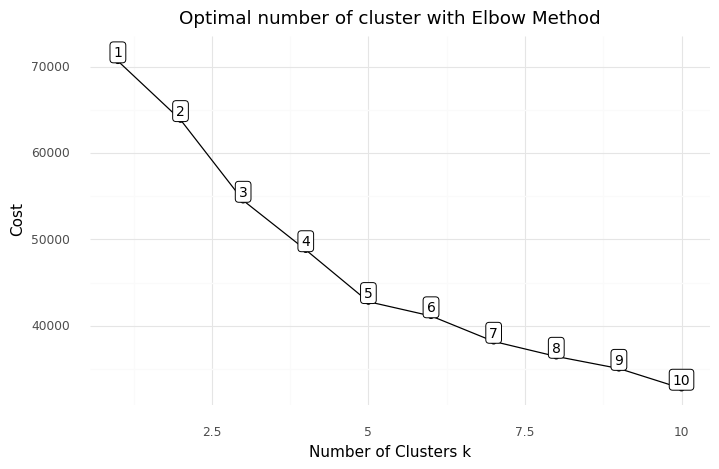

<ggplot: (8772487422645)>

In [29]:
# Codo
plotnine.options.figure_size = (8, 4.8)
(
ggplot(data = df_cost)+
geom_line(aes(x = 'Cluster',
y = 'Cost'))+
geom_point(aes(x = 'Cluster',
y = 'Cost'))+
geom_label(aes(x = 'Cluster',
y = 'Cost',
label = 'Cluster'),
size = 10,
nudge_y = 1000) +
labs(title = 'Optimal number of cluster with Elbow Method')+
xlab('Number of Clusters k')+
ylab('Cost')+
theme_minimal()
)

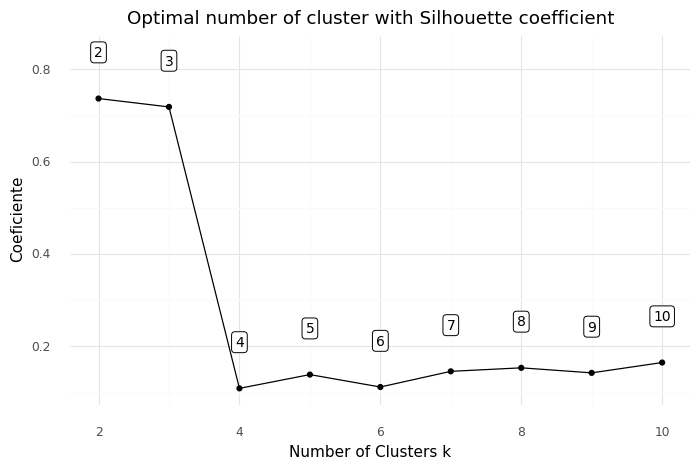

<ggplot: (8772487241329)>

In [30]:
# Coeficiente silueta
plotnine.options.figure_size = (8, 4.8)
(
ggplot(data = df_silueta)+
geom_line(aes(x = 'Cluster',
y = 'Coeficiente'))+
geom_point(aes(x = 'Cluster',
y = 'Coeficiente'))+
geom_label(aes(x = 'Cluster',
y = 'Coeficiente',
label = 'Cluster'),
size = 10,
nudge_y = 0.1) +
labs(title = 'Optimal number of cluster with Silhouette coefficient')+
xlab('Number of Clusters k')+
ylab('Coeficiente')+
theme_minimal()
)

In [50]:
dfNoSupervisado1.head()

,AISLE,IG,HTS,PLANNING,ABC,UOM,CAT,COSTX,QTYVAR,Cluster
0,17,IG56,HTS119,1/1,B,PC,CAT17,-0.029976,-0.037185,0
1,17,IG56,HTS119,1/1,B,PC,CAT17,0.092472,-0.006928,0
2,17,IG56,HTS119,1/1,C,PC,CAT17,0.266130,0.020450,0
3,17,IG56,HTS119,1/1,B,PC,CAT17,-0.025112,-0.044259,0
4,15,IG56,HTS119,1/1,C,PC,CAT17,-0.077982,-0.046471,0


In [35]:
# Fit the cluster 
k = 3
gamma = 0.5
import time
start_time = time.time()
kprototype = KPrototypes(n_jobs = -1, n_clusters = k, init = 'Huang', gamma = gamma, random_state = 0)
kprototype.fit_predict(dfNoSupervisado1, categorical = catColumnsPos)
print("--- %s seconds ---" % (time.time() - start_time))

--- 141.9151372909546 seconds ---


In [36]:
dfNoSupervisado1['Cluster'] = kprototype.labels_

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

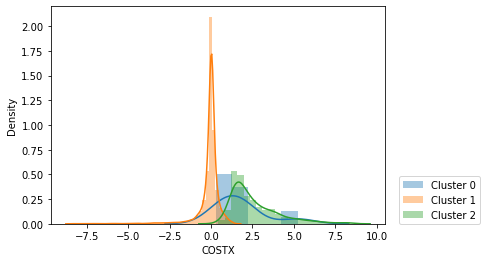

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

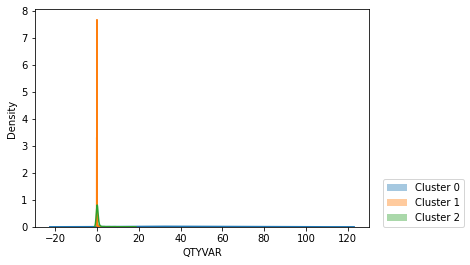

In [38]:
import matplotlib.pylab as plt
for var in ['COSTX','QTYVAR']:
    for i in range(k):
        sns.distplot(dfNoSupervisado1.loc[dfNoSupervisado1['Cluster']==i,var], label= 'Cluster {}'.format(i));
        plt.legend(loc=(1.04,0))
    plt.show();

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


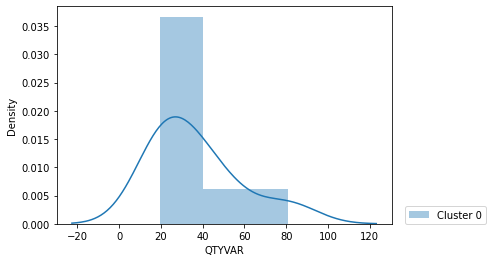

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


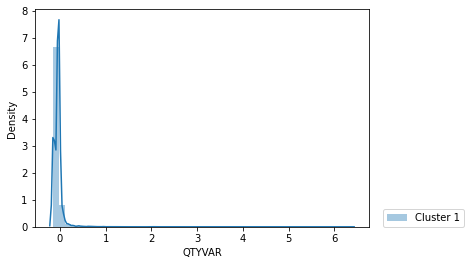

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


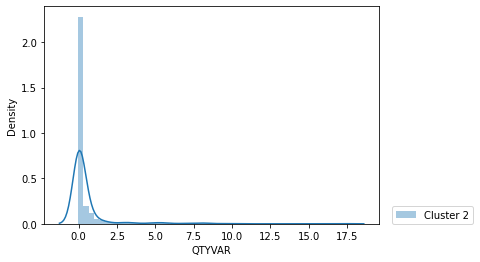

In [39]:
for i in range(k):
    sns.distplot(dfNoSupervisado1.loc[dfNoSupervisado1['Cluster']==i,'QTYVAR'], label= 'Cluster {}'.format(i));
    plt.legend(loc=(1.04,0))
    plt.show()

In [41]:
# Dataset original sin estandarizar
dfNoSupervisado1['Cluster'] = kprototype.labels_
for i in range(k):
  print('Cluster',i,'\n');
  print(dfNoSupervisado1[dfNoSupervisado1['Cluster']==i].describe());
  print('\n');

Cluster 0 

          COSTX     QTYVAR  Cluster
count  8.000000   8.000000      8.0
mean   1.785875  36.711458      0.0
std    1.541548  21.316009      0.0
min    0.274541  19.567773      0.0
25%    0.955144  21.268382      0.0
50%    1.468887  30.135373      0.0
75%    1.978412  41.759734      0.0
max    5.247262  80.947463      0.0


Cluster 1 

              COSTX        QTYVAR  Cluster
count  15532.000000  15532.000000  15532.0
mean      -0.118148     -0.040585      1.0
std        0.791615      0.180356      0.0
min       -8.424643     -0.143814      1.0
25%       -0.135331     -0.102748      1.0
50%        0.018345     -0.036977      1.0
75%        0.122100     -0.030768      1.0
max        1.454161      6.353706      1.0


Cluster 2 

            COSTX      QTYVAR  Cluster
count  699.000000  699.000000    699.0
mean     2.604845    0.481661      2.0
std      1.468196    1.506242      0.0
min      0.450340   -0.033210      2.0
25%      1.554592   -0.033210      2.0
50%      2.1452

In [43]:
# Dataset original sin estandarizar
dfTest1['Cluster'] = kprototype.labels_
for i in range(k):
  print('Cluster',i,'\n');
  print(dfTest1[dfTest1['Cluster']==i].describe());
  print('\n');

Cluster 0 

              COSTX        QTYVAR  Cluster
count      8.000000      8.000000      8.0
mean    8302.833038  33555.073750      0.0
std     7294.693408  19465.108337      0.0
min     1151.114100  17900.000000      0.0
25%     4371.767625  19452.942500      0.0
50%     6802.826900  27550.000000      0.0
75%     9213.929625  38165.000000      0.0
max    24682.320000  73950.000000      0.0


Cluster 1 

              COSTX        QTYVAR  Cluster
count  15532.000000  15532.000000  15532.0
mean    -707.112861     -5.735252      1.0
std     3745.968015    164.695438      0.0
min   -40013.935000   -100.000000      1.0
25%     -788.423550    -62.500000      1.0
50%      -61.222450     -2.440000      1.0
75%      429.755300      3.230000      1.0
max     6733.146600   5833.330000      1.0


Cluster 2 

              COSTX        QTYVAR  Cluster
count    699.000000    699.000000    699.0
mean   12178.247490    471.164120      2.0
std     6947.590303   1375.452602      0.0
min     1983.0

In [51]:
dfNoSupervisado1.drop('Cluster', inplace=True, axis=1)

In [52]:
dfNoSupervisado1.head()

,AISLE,IG,HTS,PLANNING,ABC,UOM,CAT,COSTX,QTYVAR
0,17,IG56,HTS119,1/1,B,PC,CAT17,-0.029976,-0.037185
1,17,IG56,HTS119,1/1,B,PC,CAT17,0.092472,-0.006928
2,17,IG56,HTS119,1/1,C,PC,CAT17,0.266130,0.020450
3,17,IG56,HTS119,1/1,B,PC,CAT17,-0.025112,-0.044259
4,15,IG56,HTS119,1/1,C,PC,CAT17,-0.077982,-0.046471


In [53]:
# Fit the cluster 
k = 2
gamma = 0.5
import time
start_time = time.time()
kprototype = KPrototypes(n_jobs = -1, n_clusters = k, init = 'Huang', gamma = gamma, random_state = 0)
kprototype.fit_predict(dfNoSupervisado1, categorical = catColumnsPos)
print("--- %s seconds ---" % (time.time() - start_time))

--- 138.98487663269043 seconds ---


In [55]:
dfNoSupervisado1['Cluster'] = kprototype.labels_

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


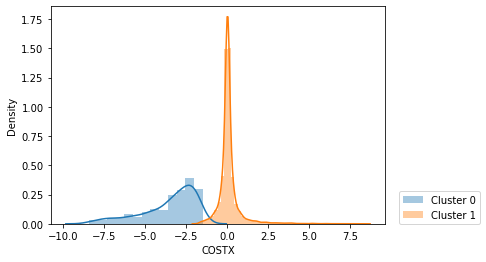

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


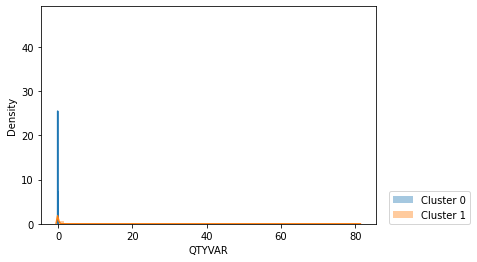

In [56]:
import matplotlib.pylab as plt
for var in ['COSTX','QTYVAR']:
    for i in range(k):
        sns.distplot(dfNoSupervisado1.loc[dfNoSupervisado1['Cluster']==i,var], label= 'Cluster {}'.format(i));
        plt.legend(loc=(1.04,0))
    plt.show();

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


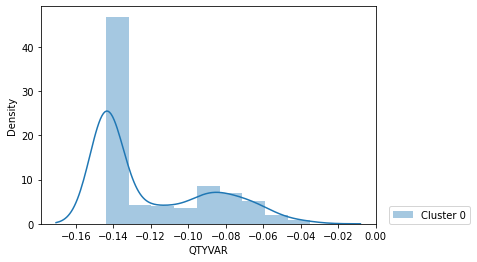

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


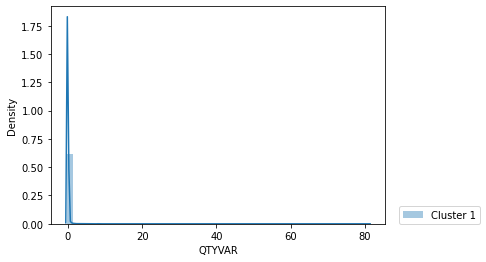

In [57]:
for i in range(k):
    sns.distplot(dfNoSupervisado1.loc[dfNoSupervisado1['Cluster']==i,'QTYVAR'], label= 'Cluster {}'.format(i));
    plt.legend(loc=(1.04,0))
    plt.show()

In [58]:
# Dataset original sin estandarizar
dfNoSupervisado1['Cluster'] = kprototype.labels_
for i in range(k):
  print('Cluster',i,'\n');
  print(dfNoSupervisado1[dfNoSupervisado1['Cluster']==i].describe());
  print('\n');

Cluster 0 

            COSTX      QTYVAR  Cluster
count  517.000000  517.000000    517.0
mean    -3.519287   -0.119653      0.0
std      1.665826    0.031036      0.0
min     -8.424643   -0.143814      0.0
25%     -4.421132   -0.143814      0.0
50%     -3.001296   -0.143814      0.0
75%     -2.241218   -0.089870      0.0
max     -1.483766   -0.034765      0.0


Cluster 1 

              COSTX        QTYVAR  Cluster
count  15722.000000  15722.000000  15722.0
mean       0.115728      0.003935      1.0
std        0.721921      1.016086      0.0
min       -1.818022     -0.143814      1.0
25%       -0.098211     -0.087970      1.0
50%        0.028739     -0.034814      1.0
75%        0.169385     -0.028380      1.0
max        8.422908     80.947463      1.0




In [59]:
# Dataset original sin estandarizar
dfTest1['Cluster'] = kprototype.labels_
for i in range(k):
  print('Cluster',i,'\n');
  print(dfTest1[dfTest1['Cluster']==i].describe());
  print('\n');

Cluster 0 

              COSTX      QTYVAR  Cluster
count    517.000000  517.000000    517.0
mean  -16801.499913  -77.937485      0.0
std     7882.786495   28.341484      0.0
min   -40013.935000 -100.000000      0.0
25%   -21069.087000 -100.000000      0.0
50%   -14350.339300 -100.000000      0.0
75%   -10753.602400  -50.740000      0.0
max    -7169.298600   -0.420000      0.0


Cluster 1 

              COSTX        QTYVAR  Cluster
count  15722.000000  15722.000000  15722.0
mean     399.600315     34.919097      1.0
std     3416.171536    927.858131      0.0
min    -8751.015300   -100.000000      1.0
25%     -612.771325    -49.005000      1.0
50%      -12.033700     -0.465000      1.0
75%      653.507700      5.410000      1.0
max    39709.661400  73950.000000      1.0




In [61]:
pd.set_option('display.max_columns', None)
for i in range(k):
  print('\033[1m' + '\033[91m' + 'Cluster ',i, '\033[0m' + '\n')
  contingency = pd.crosstab(dfNoSupervisado1[dfNoSupervisado1['Cluster']==i].Cluster, dfNoSupervisado1[dfNoSupervisado1['Cluster']==i].CAT) 
  print(contingency,'\n')
pd.options.display.max_columns = 10

Cluster  0 

CAT      CAT1  CAT10  CAT12  CAT14  CAT15  CAT16  CAT17  CAT2  CAT3  CAT4  \
Cluster                                                                     
0           5      6    112    196      1     41     33     2    17     7   

CAT      CAT5  CAT7  CAT8  
Cluster                    
0          12    28    57   

Cluster  1 

CAT      CAT1  CAT10  CAT11  CAT12  CAT14  CAT15  CAT16  CAT17  CAT2  CAT3  \
Cluster                                                                      
1         140    245      1   2445   1942     82   2414   3953   188   502   

CAT      CAT4  CAT5  CAT6  CAT7  CAT8  CAT9  
Cluster                                      
1          97   188     7  1194  2164   160   

